# Turbine check-out/calibration notebook

Use this notebook to set up a series of runs for turbine calibration and check-out

In [1]:
%%capture 

# Important header information
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import matplotlib.pyplot    as plt
import amrwind_frontend as amrwind
import tempfile
import shutil
# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

**Note**: Make sure there is a turbine file which looks like:

In [2]:
with open(amrwindfedir+"/turbines/IEA15MW.yaml")as f: print(f.read())

turbines:
  IEA15MW_Joukowski:     # This is an arbitrary, unique name
    turbinetype_name:    "IEA15MW_Joukowsky"
    turbinetype_comment: "Dummy layout"   # arbitrary
    Actuator_type:                JoukowskyDisk
    Actuator_rotor_diameter:      240
    Actuator_hub_height:          150     # Double-check
    Actuator_output_frequency:    10                   
    # --------------------
    Actuator_diameters_to_sample: 5.0     # How far upstream to sample inflow wind
    #Actuator_epsilon:             [5.0]   # Epsilon in Z (might need to play with this guy)
    Actuator_num_points_r:        40      # number of radial (might need to play with this guy)
    Actuator_num_points_t:        5       # number of pts in theta (might need to play with this guy)
    #Actuator_vortex_core_size:    24.0    # might need to play with this
    # --------------------
    # These will come from
    # https://github.com/IEAWindTask37/IEA-15-240-RWT/blob/master/performance/performance_ccblade.dat


Note that both `Actuator_epsilon` and `Actuator_epsilon_tower` are commented out.  We can set those values later.

In [3]:
# Start the amrwind_frontend app 
case = amrwind.MyApp.init_nogui()

In [4]:
curdir=os.getcwd()

# Create a temporary working directory and switch to it
tempdir = tempfile.mkdtemp(prefix='tempturbine-')
os.chdir(tempdir)
print('Using temporary directory: '+tempdir)

Using temporary directory: /tmp/tempturbine-o95En6


## Set up the basic simulation properties

In [5]:
rhodensity = 1.0
WS         = 11.0                                     # This is temporary, we will vary across a range below
eps        = 5.0
vortex_core = 24.0
case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)
case.setAMRWindInput('ABL_winddir', 270,  forcechange=True)
case.ABL_calculateWindVector()

In [6]:
case.setAMRWindInput('time_control',   ['const dt'])
case.setAMRWindInput('time.stop_time', 360)
case.setAMRWindInput('time.fixed_dt',  0.1)
case.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])

In [7]:
case.setAMRWindInput('ConstValue.density.value',  rhodensity)
case.setAMRWindInput('incflo.density',            rhodensity)
case.setAMRWindInput('incflo.velocity',           [WS, 0.0, 0.0])
case.setAMRWindInput('ConstValue.velocity.value', [WS, 0.0, 0.0])
case.setAMRWindInput('turbulence.model',          ['Laminar'])

## Set the BC's

In [8]:
case.setAMRWindInput('is_periodicx', False)
case.setAMRWindInput('is_periodicy', True)
case.setAMRWindInput('is_periodicz', True)  # False?

case.setAMRWindInput('xlo.type', 'mass_inflow')
case.setAMRWindInput('xhi.type', 'pressure_outflow')
case.setAMRWindInput('xlo.density',  rhodensity)
case.setAMRWindInput('xlo.velocity', [WS, 0.0, 0.0])

### Set up the turbine in the domain

In [9]:
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,     0, 0, IEA15MW_Joukowsky, , 0.0,
"""
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [10]:
case.setAMRWindInput('turbines_domainsize', [2560.0*2, 960.0*2, 960.0*2])
case.setAMRWindInput('turbines_freespace', True)   # Make this have no ground
case.setAMRWindInput('turbines_backgroundmeshsize', 20.0)
case.setAMRWindInput('turbines_deleteprev', True)

#case.setAMRWindInput('zlo_type', 'slip_wall')
#case.setAMRWindInput('zhi_type', 'slip_wall')

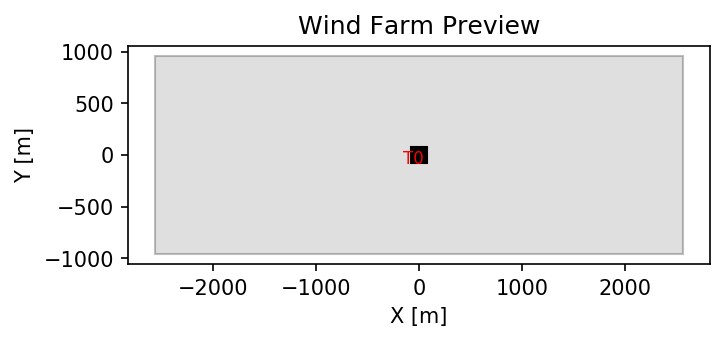

In [11]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [12]:
# Now create the turbines
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
['T0']


In [13]:
# Set some globals
case.setAMRWindInput('Actuator_default_type', ['JoukowskyDisk'])
case.setAMRWindInput('Actuator_JoukowskyDisk_epsilon',       [eps], forcechange=True)  # You can change this
case.setAMRWindInput('Actuator_JoukowskyDisk_vortex_core_size', vortex_core, forcechange=True)  # You can change this

## Add turbine refinement regions

In [14]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     10,       10,         3,       2,     2,     center:farm   # 10m refinement
1,     2.5,      2.5,        2.5,     1.2,   1.2,   center:farm   # 5m refinement
#2,     1,        1,          0.75,    0.8,   0.8,  
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [15]:
case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm_level_0_zone', 'Farm_level_1_zone']


Plotting turbines


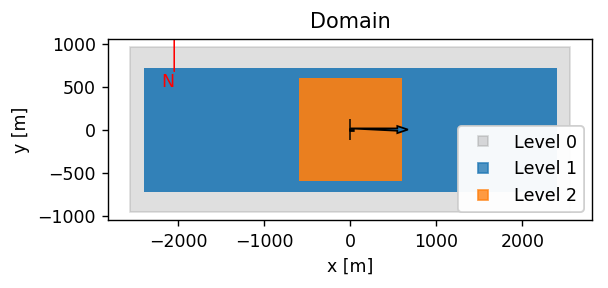

In [16]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

Plotting turbines


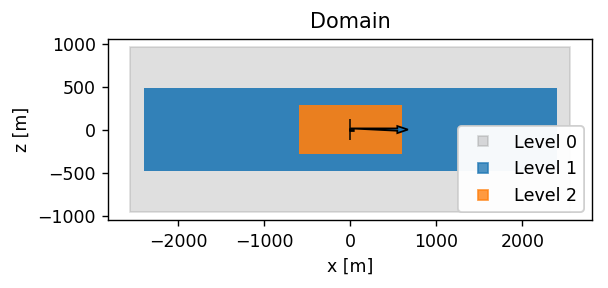

In [17]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ'
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

In [18]:
case.estimateMeshSize()

Refinement Farm_level_0_zone: level 1: 6635520 cells
Refinement Farm_level_1_zone: level 2: 6635520 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0      2359296             20.0 x 20.0 x 20.0
       1      6635520             10.0 x 10.0 x 10.0
       2      6635520                5.0 x 5.0 x 5.0
  TOTAL:     15630336


### Create sampling planes

In [19]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
hh,  hubheight,2560,2560,960, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [20]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_hh']


Plotting turbines


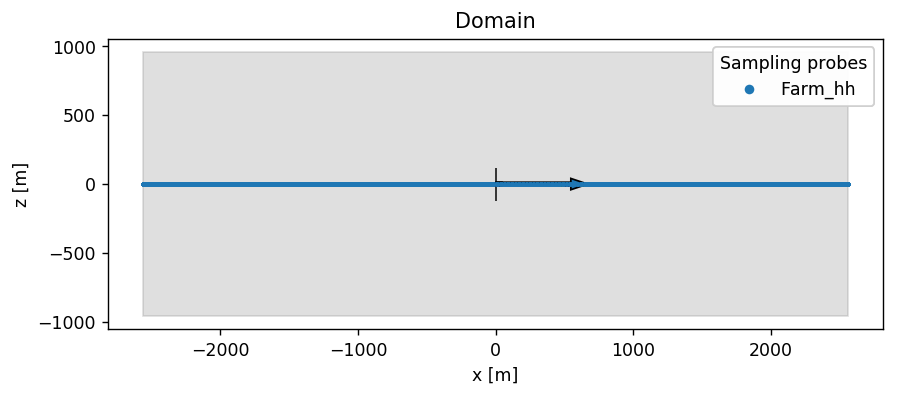

In [21]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.plotDomain(ax=ax)

In [22]:
print(case.writeAMRWindInput(''))

# --- Simulation time control parameters ---
time.stop_time                           = 360.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
incflo.physics                           = FreeStream Actuator # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = Laminar             
incflo.gravity                           = 0.0 0.0 -9.81       # Gravitational acceleration vector (x,y,z) [m/s^2]
incflo.density                           = 1.0                 # Fluid density [kg/m^3]
transport.viscosity 

In [23]:
# Clean up the temporary directory
docleanup = True
os.chdir(curdir)
if docleanup:
    try:
        shutil.rmtree(tempdir)
    except:
        print("Error cleaning up: "+tempdir)

## Set up a wind sweep

In [24]:
# Set the parameters
case.setAMRWindInput('sweep_windspeeds', '7 9 10 11')
case.setAMRWindInput('sweep_winddirs',   '270')
case.setAMRWindInput('sweep_caseprefix', 'CalibrateIEA15MW_{CASENUM}_EPS%0.2f_WS_{WS}'%eps)
case.setAMRWindInput('sweep_dirprefix',  'CalibrateIEA15MW_{CASENUM}_EPS%0.2f_WS_{WS}'%eps)
case.setAMRWindInput('sweep_usenewdirs', True)
case.setAMRWindInput('sweep_logfile',    'RunCalibration_Eps%0.2f_logfile.yaml'%eps)

In [25]:
# Submission parameters
case.popup_storteddata['submitscript']['submitscript_numnodes'] = 10
case.popup_storteddata['submitscript']['submitscript_runtime']  = '8:00:00'
case.popup_storteddata['submitscript']['submitscript_wcid']     = 'fy210193'
case.popup_storteddata['submitscript']['submitscript_partition']= 'batch'
case.popup_storteddata['submitscript']['submitscript_corespernode'] = 16
case.popup_storteddata['submitscript']['submitscript_queue']    = 'normal'
case.popup_storteddata['submitscript']['submitscript_jobname']  = 'IEA15MW'

case.setAMRWindInput('sweep_createsubmitscript', True)
case.setAMRWindInput('sweep_submitjob',          True)

In [26]:
# Set up the cases
case.sweep_SetupRunParamSweep(verbose=True)

       NUM           WS         WDir            Case name
       ---           --         ----            ---------
         0      7.00000    270.00000 CalibrateIEA15MW_0_EPS5.00_WS_7.0
Saved CalibrateIEA15MW_0_EPS5.00_WS_7.0.sh
Executing: sbatch CalibrateIEA15MW_0_EPS5.00_WS_7.0.sh
sbatch: INFO: Adding filesystem licenses to job: gpfs:1,nscratch:1,pscratch:1
Submitted batch job 28127286

         1      9.00000    270.00000 CalibrateIEA15MW_1_EPS5.00_WS_9.0
Saved CalibrateIEA15MW_1_EPS5.00_WS_9.0.sh
Executing: sbatch CalibrateIEA15MW_1_EPS5.00_WS_9.0.sh
sbatch: INFO: Adding filesystem licenses to job: gpfs:1,nscratch:1,pscratch:1
Submitted batch job 28127287

         2     10.00000    270.00000 CalibrateIEA15MW_2_EPS5.00_WS_10.0
Saved CalibrateIEA15MW_2_EPS5.00_WS_10.0.sh
Executing: sbatch CalibrateIEA15MW_2_EPS5.00_WS_10.0.sh
sbatch: INFO: Adding filesystem licenses to job: gpfs:1,nscratch:1,pscratch:1
Submitted batch job 28127288

         3     11.00000    270.00000 CalibrateIEA1

### Save the calibration

In [27]:
# Save the wind farm setup
case.setAMRWindInput('farm_usercomments', 'Test calibration process.')
case.writeFarmSetupYAML('TurbineCalibrate_IEA15MW_Eps%0.2f.yaml'%eps)

Saved farm setup to TurbineCalibrate_IEA15MW_Eps5.00.yaml
